In [37]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# load the image
img1 = cv.imread('college/3.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('college/4.jpg', cv.IMREAD_GRAYSCALE)

In [39]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [40]:
# Visualize keypoints
imgSift = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# resize the image
imgSift = cv.resize(imgSift, (0, 0), fx=0.2, fy=0.2)
cv.imshow("SIFT Keypoints", imgSift)
cv.waitKey(0)
cv.destroyAllWindows()

In [28]:
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)   # or pass empty dictionary
# flann = cv.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(des1, des2, k=2)

In [41]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.65*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)



In [30]:
# Draw good matches
img3 = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches, None, matchesMask=matchesMask, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3 = cv.resize(img3, (0, 0), fx=0.2, fy=0.2)
cv.imshow("SIFT Matches", img3)
cv.waitKey(0)
cv.destroyAllWindows()

In [31]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

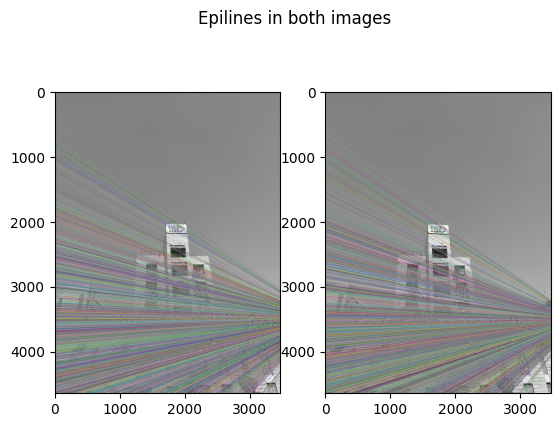

In [32]:
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c= img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    # np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)


lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [33]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

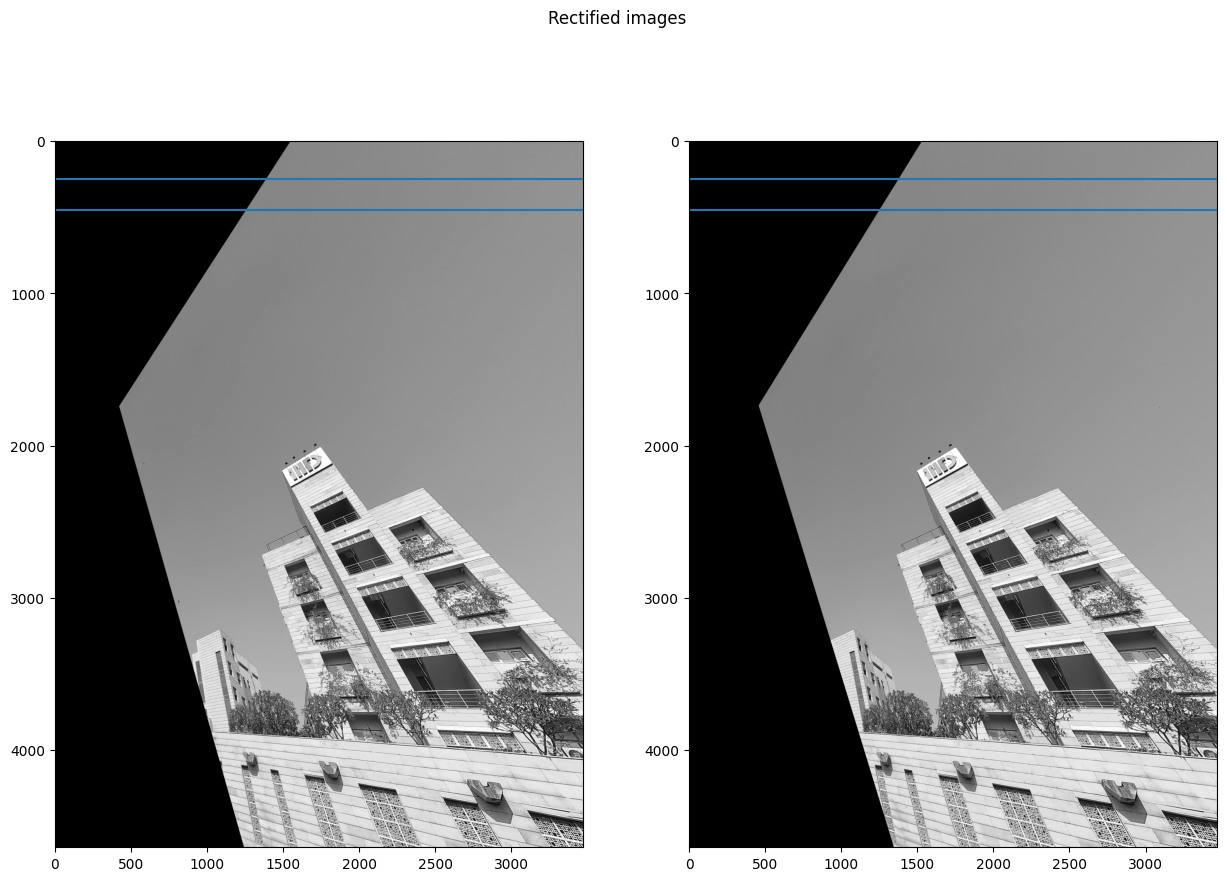

In [34]:
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
# plt.savefig("rectified_images.png")
plt.show()

In [35]:
block_size = 10
min_disp = -128
max_disp = 128

num_disp = max_disp - min_disp
uniquenessRatio = 15
speckleWindowSize = 200
speckleRange = 5
disp12MaxDiff = 5

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
disparity_SGBM = np.uint8(disparity_SGBM)
cv.waitKey(0)
cv.destroyAllWindows()

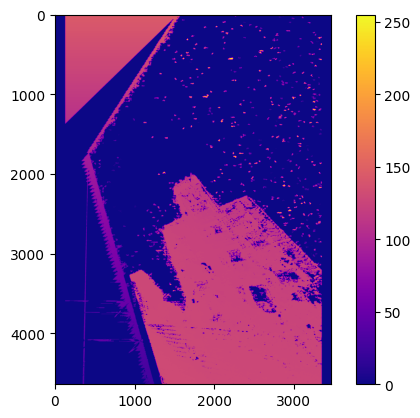

In [36]:
plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()